In [140]:
import pandas as pd
import numpy as np
# Function to process CSV files
def process_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        # Perform some processing on the DataFrame
        df.fillna(0, inplace=True)  # Example: Fill NaN values with 0
        return df
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Example usage
input_file_path = "Derivative_Prices.csv"
processed_df = process_csv(input_file_path)
derivative_price = processed_df['Prices'][1:]


# Example usage
SMI_price_path = "SMI_Prices.csv"
underlying_price = process_csv(SMI_price_path)['Close']
print(underlying_price)



0     11543.25
1     11510.46
2     11843.18
3     11827.43
4     11865.93
        ...   
59    12184.00
60    12237.97
61    12100.57
62    11967.70
63    11792.92
Name: Close, Length: 64, dtype: float64


In [166]:
ans = []
for i in range(len(underlying_price)):
    ans.append(payoff([underlying_price[i]]))

print(ans)
print(len(ans))


[np.float64(1046.3604763154015), np.float64(1042.6780073384339), np.float64(1080.0440054481223), np.float64(1078.2752074491214), np.float64(1082.5989358911238), np.float64(1083.4726659503126), np.float64(1089.5854072255902), np.float64(1105.7224602082217), np.float64(1114.5260205346776), np.float64(1118.8508720230286), np.float64(1128.5663459845252), np.float64(1127.5915417539645), np.float64(1125.7441305105638), np.float64(1131.9590690035614), np.float64(1136.6769867139124), np.float64(1137.4507656480785), np.float64(1130.978649541258), np.float64(1136.8162444611353), np.float64(1144.5675103589795), np.float64(1146.6866988187348), np.float64(1148.3589148317585), np.float64(1136.7589690973582), np.float64(1117.440325809222), np.float64(1101.1752455428536), np.float64(1087.350544991932), np.float64(1095.4814005555936), np.float64(1093.6923877223182), np.float64(1088.9980539852872), np.float64(1095.6723184348507), np.float64(1101.8423350739054), np.float64(1098.269924639098), np.float64(

In [141]:
import numpy as np
import math
from gbm_func import *
# import importlib
# importlib.reload(gbm)

# Input array of prices and volatilities
derivative_price = processed_df['Prices'][1:]
underlying_price = process_csv(SMI_price_path)['Close'] #TODO
volatility = [0.1666 for i in range(70)] #TODO


starting_N = 258
N = len(derivative_price)
dt = 1/252
inital_price = 11130.44
r = 0.01
Nsim = 100
# sigma = 0.136 


In [142]:
print(N)

64


In [143]:
def backtest(underlying_price, volatility, Nsim, func):
    starting_N = 258
    price = [0 for i in range(len(derivative_price))]
    for i in range(len(derivative_price)):
        N = starting_N - i
        current_price = underlying_price[i]
        current_volatility = volatility[i]

        sim_prices = func(current_volatility, N, current_price, r = 0.01, Nsim = Nsim)
        payoff_prices = payoff_sim(sim_prices, N, r)
        price[i] = np.mean(payoff_prices)
    return price



In [159]:
price_with_GBM =backtest(underlying_price, volatility, Nsim = 1000, func = GBM)

In [145]:
def GBM_CV(sigma, N, S_0, r = 0.01 , Nsim = 10000):
    starting_N = 258
    dt = 1/252
    
    first_N = 100
    S_first_N = GBM(sigma, N, S_0, Nsim = first_N)
    derivative_price_first_N = payoff_sim(S_first_N, N)

    c = -np.cov(derivative_price_first_N, S_first_N[:,-1])[0][1] / (S_0 ** 2 * np.exp(2 * r * N * dt) * (np.exp(sigma ** 2 * N * dt) - 1))
    S_N2 = GBM(sigma, N, S_0 , Nsim = Nsim)
    derivative_price_N2= payoff_sim(S_N2, N)
    derivative_price_actual_sim_N_CV = derivative_price_N2 + c * (S_N2[:,-1] - [S_0 * np.exp(r * N * dt) for _ in range(Nsim)] )
    return derivative_price_actual_sim_N_CV

def backtest_CV(underlying_price, volatility, Nsim):
    starting_N = 258
    price = [0 for _ in range(len(derivative_price))]
    for i in range(len(derivative_price)):
        N = starting_N - i
        current_price = underlying_price[i]
        current_volatility = volatility[i]
        price[i] = np.mean(GBM_CV(current_volatility, N, current_price, r = 0.01, Nsim = Nsim))
    return price


In [146]:
price_with_CV = backtest_CV(underlying_price, volatility, Nsim = 100)

In [147]:
price_with_AV  = backtest(underlying_price, volatility, Nsim = 100, func = GBM_AV)

In [148]:
price_with_SS = backtest(underlying_price, volatility, Nsim = 100, func = gbm_SS)

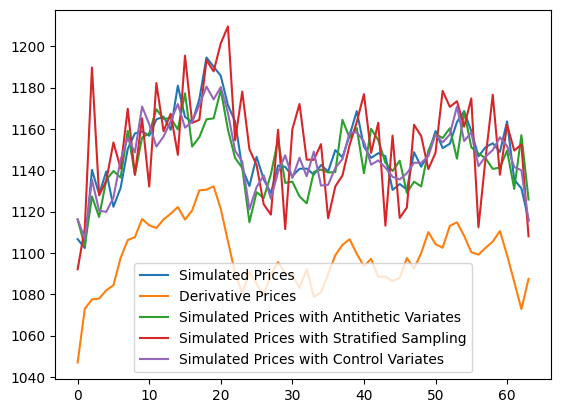

In [169]:
t = np.arange(0, len(derivative_price), 1)
import matplotlib.pyplot as plt
plt.plot(t, price_with_GBM)
plt.plot(t, derivative_price)
plt.plot(t, price_with_AV)
plt.plot(t, price_with_SS)
plt.plot(t, price_with_CV)

# plt.plot(t, ans, color = 'black')
plt.legend(['Simulated Prices', 'Derivative Prices', 'Simulated Prices with Antithetic Variates', 'Simulated Prices with Stratified Sampling', 'Simulated Prices with Control Variates'])
plt.show()

In [171]:
# print(derivative_price)

In [170]:
# print(price_with_GBM)

In [172]:
# Generate RMS error for each method
def RMS_error(correct_price, predicted_price):
    return np.sqrt(np.mean((correct_price - predicted_price) ** 2))

print(RMS_error(derivative_price, price_with_GBM))
print(RMS_error(derivative_price, price_with_AV))
print(RMS_error(derivative_price, price_with_SS))
print(RMS_error(derivative_price, price_with_CV))

51.636539371599945
48.76634706397669
58.32501237062352
49.63948138796254


In [151]:
def get_delta(sigma, N, S_0,  r = 0.01 , Nsim = 10000, barrier_price = 6566.9596, delta = 0.01):
    # Create a 2D array to store the stock prices for each simulation
    S = np.zeros([Nsim,N])
    S_plus = np.zeros([Nsim,N])
    S_minus = np.zeros([Nsim,N])

    S[:,0] = S_0
    S_plus[:,0] = S_0 * (1 + delta)
    S_minus[:,0] = S_0 * (1 - delta)

    for i in range(Nsim):
        S[i,0]=S_0
        for j in range(N-1):
            Z = np.random.normal(0, 1)
            
            # Calculate the stock price at time t+1 using the Geometric Brownian Motion model with risk-free interet rate
            S[i,j+1] = S[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            S_plus[i,j+1] = S_plus[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            S_minus[i,j+1] = S_minus[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )

            
    # Calculate the expected final price of the derivative discounted to present value
    exact = payoff_sim(S, N, r=0.01)
    exact_plus = payoff_sim(S_plus, N, r=0.01)
    exact_minus = payoff_sim(S_minus, N, r=0.01)

    plus = np.mean(exact_plus)
    minus = np.mean(exact_minus)
    exact = np.mean(exact)
    # print(f'{plus  = }, {minus = }, {exact = }, Notedelta = {(plus - minus) / (2 * S_0 * delta)}')
    delta = (plus - minus) / (2 * S_0 * delta)
    gamma = (plus - 2 * exact + minus) / (S_0 * delta ** 2)
    return (delta, gamma)

In [152]:
def backtest_delta(underlying_price, volatility, Nsim):
    delta_arr = [0 for i in range(len(derivative_price))]
    gamma_arr = [0 for i in range(len(derivative_price))]
    # price = [0 for i in range(len(derivative_price))]
    for i in range(len(derivative_price)):
        N = starting_N - i
        current_price = underlying_price[i]
        current_volatility = volatility[i]

        delta, gamma = get_delta(current_volatility, N, current_price, r = 0.01, Nsim = Nsim)
        delta_arr[i] = delta
        gamma_arr[i] = gamma
    return delta_arr, gamma_arr


In [153]:
delta, gamma = backtest_delta(underlying_price, volatility, Nsim = 100)

In [154]:
print(f'delta = {delta}\n gamma = {gamma}')

delta = [np.float64(0.0764692805960647), np.float64(0.07011156186230195), np.float64(0.08236876614373759), np.float64(0.08853227081537085), np.float64(0.08276048004917454), np.float64(0.07463113455688204), np.float64(0.07278267970608537), np.float64(0.08038954453030915), np.float64(0.08655675139398065), np.float64(0.09251044269861629), np.float64(0.07870152487415727), np.float64(0.08534154416468596), np.float64(0.08374525511590353), np.float64(0.08695500533698512), np.float64(0.08906559860948793), np.float64(0.08487087562492585), np.float64(0.08944631984525887), np.float64(0.08999869397068103), np.float64(0.09108857663599153), np.float64(0.09940290535908783), np.float64(0.09824444033607871), np.float64(0.08824772895545951), np.float64(0.08225424932688125), np.float64(0.07827315173264802), np.float64(0.07568839823479663), np.float64(0.07495740026633016), np.float64(0.07745605365465047), np.float64(0.08421839266381739), np.float64(0.08554653206372505), np.float64(0.07694194556258437), np